In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tqdm
import itertools
from pathlib import Path

In [9]:
price_df = pd.read_csv('dataset/BTCUSDT-1min.csv',
                 index_col='date',
                 parse_dates=['date'])
price_df = price_df[['open', 'high', 'low', 'close']]
price_df.sort_index(inplace=True)
price_df = price_df.loc['2018-01-01':]
price_df

open      high       low     close
date                                                       
2018-01-01 00:00:00  13715.65  13715.65  13681.00  13707.92
2018-01-01 00:01:00  13707.91  13707.91  13666.11  13694.92
2018-01-01 00:02:00  13682.00  13694.94  13680.00  13680.00
2018-01-01 00:03:00  13679.98  13679.98  13601.00  13645.99
2018-01-01 00:04:00  13645.98  13646.00  13576.28  13600.00
...                       ...       ...       ...       ...
2021-09-04 15:56:00  49845.77  49856.55  49821.46  49821.46
2021-09-04 15:57:00  49821.47  49836.10  49800.86  49800.88
2021-09-04 15:58:00  49800.88  49826.93  49793.07  49826.92
2021-09-04 15:59:00  49826.92  49882.09  49826.92  49873.53
2021-09-04 16:00:00  49873.52  49873.53  49848.10  49850.43

[1925576 rows x 4 columns]

In [10]:
CAPITAL = 1000
FEE = 0.07

### Fee
binance fee 0.07 %

coinbase 0.1 %

## Buy & Hold BTC

In [11]:
def buy_and_hold_by_ratio(price_df, asset_ratio, capital):
    cash_ratio = 1 - asset_ratio
    
    buy_and_hold_df = price_df.copy()
    
    price = buy_and_hold_df['close'].iloc[0]
    buy_and_hold_df['asset_amount'] = asset_ratio * capital / price
    buy_and_hold_df['asset_value'] = buy_and_hold_df['asset_amount'] * buy_and_hold_df['close']
    buy_and_hold_df['cash'] = cash_ratio * capital
    buy_and_hold_df['nav'] = buy_and_hold_df['asset_value'] + buy_and_hold_df['cash']
    return buy_and_hold_df
buy_and_hold_by_ratio(price_df, asset_ratio=0.5, capital=CAPITAL)

open      high       low     close  asset_amount  \
date                                                                        
2018-01-01 00:00:00  13715.65  13715.65  13681.00  13707.92      0.036475   
2018-01-01 00:01:00  13707.91  13707.91  13666.11  13694.92      0.036475   
2018-01-01 00:02:00  13682.00  13694.94  13680.00  13680.00      0.036475   
2018-01-01 00:03:00  13679.98  13679.98  13601.00  13645.99      0.036475   
2018-01-01 00:04:00  13645.98  13646.00  13576.28  13600.00      0.036475   
...                       ...       ...       ...       ...           ...   
2021-09-04 15:56:00  49845.77  49856.55  49821.46  49821.46      0.036475   
2021-09-04 15:57:00  49821.47  49836.10  49800.86  49800.88      0.036475   
2021-09-04 15:58:00  49800.88  49826.93  49793.07  49826.92      0.036475   
2021-09-04 15:59:00  49826.92  49882.09  49826.92  49873.53      0.036475   
2021-09-04 16:00:00  49873.52  49873.53  49848.10  49850.43      0.036475   

                     asset_value   cash          nav  
date                                                  
2018-01-01 00:00:00   500.000000  500.0  1000.000000  
2018-01-01 00:01:00   499.525822  500.0   999.525822  
2018-01-01 00:02:00   498.981611  500.0   998.981611  
2018-01-01 00:03:00   497.741087  500.0   997.741087  
2018-01-01 00:04:00   496.063590  500.0   996.063590  
...                          ...    ...          ...  
2021-09-04 15:56:00  1817.250903  500.0  2317.250903  
2021-09-04 15:57:00  1816.500242  500.0  2316.500242  
2021-09-04 15:58:00  1817.450058  500.0  2317.450058  
2021-09-04 15:59:00  1819.150170  500.0  2319.150170  
2021-09-04 16:00:00  1818.307592  500.0  2318.307592  

[1925576 rows x 8 columns]

In [46]:
class Broker:
    def __init__(self, price_df, capital, asset_ratio=0.5, fee=None):
        self.price_df = price_df.copy()
        self.capital = capital
        self.asset_ratio = asset_ratio
        self.fee = fee
        
        self.cash_ratio = 1 - self.asset_ratio

        self.portfolio_data = []
        
        # init
        init_index = self.price_df.index[0]
        self.asset_value = self.init_asset_value = self.capital * self.asset_ratio
        self.asset_amount = self.init_asset_amount = self.asset_value / self.price_df.loc[init_index, 'close']
        self.cash = self.capital * self.cash_ratio

        
        # Initial portfolio historical data
        self.portfolio_data.append({
            'date': init_index,
            'nav': self.capital,
            'asset_value': self.asset_value,
            'asset_amount': self.asset_amount,
            'cash': self.cash
        })
    
    def asset_value_at(self, price=None):
        if price is None:
            return self.asset_value
        else:
            return self.asset_amount * price
    
    def nav_at(self, price=None):
        return self.asset_value_at(price) + self.cash
    
    def order(self, price, asset_amount, dt=None):
        # Calculate
        position_value = price * asset_amount
        
        if self.fee is not None:
            # Fee deduction
            if asset_amount > 0:
                posterior_cash = self.cash - position_value * (1 + self.fee / 100)
            else:
                posterior_cash = self.cash - position_value * (1 - self.fee / 100)
                
        posterior_asset_amount = self.asset_amount + asset_amount
        posterior_asset_value = posterior_asset_amount * price
        
        if posterior_cash < 0 or posterior_asset_value < 0:
            return
        action = 'Buy' if asset_amount > 0 else 'Sell'
        last_asset_value = self.asset_value_at()
        last_asset_amount = self.asset_amount
        last_cash = self.cash
        last_nav = self.nav_at()
        
        # Update
        self.asset_amount = posterior_asset_amount
        self.asset_value = posterior_asset_value
        self.cash = posterior_cash
        
        self.portfolio_data.append({
            'date': dt,
            'price': price,
            'asset_value': last_asset_value,
            'asset_amount': last_asset_amount,
            'cash': last_cash,
            'nav': last_nav,

            'action': action,
            'position_value': position_value,

            'posterior_asset_value': self.asset_value_at(),
            'posterior_asset_amount': self.asset_amount,
            'posterior_cash': self.cash,
            'posterior_nav': self.nav_at(),
        })

    def export_transaction(self):
        portfolio_df = pd.DataFrame(data=self.portfolio_data).set_index('date')
        return portfolio_df
    
    def export_price(self):

        portfolio_df = self.export_transaction()
        
        # Merge to price_df
        portfolio_price_df = self.price_df.merge(portfolio_df, how='left', left_index=True, right_index=True)
        portfolio_price_df[['asset_amount', 'cash']] = portfolio_price_df[['asset_amount', 'cash']].ffill()
        portfolio_price_df['asset_value'] = portfolio_price_df['asset_amount'] * price_df['close']
        portfolio_price_df['nav'] = portfolio_price_df['asset_value'] + portfolio_price_df['cash']
        portfolio_price_df = portfolio_price_df.groupby('date').last()
        
        return portfolio_price_df
        

## Rebalancing

In [47]:
def expected_return(prices, risk_free_rate):
    return (prices.pct_change() - risk_free_rate).mean() 
def volatility(prices):
    return prices.pct_change().std()
def sharpe_ratio(prices, risk_free_rate):
    return expected_return(prices, risk_free_rate) / volatility(prices)
def max_drawdown(prices):
    cummax = prices.cummax()
    drawdown = (prices - cummax) / cummax
    return drawdown.min()

In [77]:
comparison_df = pd.DataFrame(index=price_df.index)
portfolios = {}
portfolio_prices = {}

portfolio_name = f'buy & hold BTC {100} %'
portfolio_prices[portfolio_name] = buy_and_hold_by_ratio(price_df, asset_ratio=1.0, capital=CAPITAL)
comparison_df[portfolio_name] = portfolio_prices[portfolio_name]['nav']

### Normal Rebalancing

In [78]:
def simulate_rebalancing(price_df, trigger_df, asset_ratio, capital):

    broker = Broker(price_df, capital=CAPITAL, asset_ratio=asset_ratio, fee=FEE)

    for index, dt, price in trigger_df.itertuples():
        # Update asset price / value

        original_asset_value = broker.asset_value_at(price)
        original_nav = broker.nav_at(price)

        # Calculate rebalancing

        rebalanced_asset_value = original_nav * asset_ratio
        diff_asset_value = rebalanced_asset_value - original_asset_value
        diff_asset_amount = diff_asset_value / price

        broker.order(price, diff_asset_amount, dt)
    
    return broker.export_transaction(), broker.export_price()

### Fixed asset Rebalancing

In [182]:

def simulate_fixed_asset_rebalancing(price_df, trigger_df, asset_ratio, capital):

    broker = Broker(price_df, capital=CAPITAL, asset_ratio=asset_ratio, fee=FEE)

    for index, dt, price in trigger_df.itertuples():
        # Update asset price / value

        original_asset_value = broker.asset_value_at(price)
        original_nav = broker.nav_at(price)

        # Calculate rebalancing
        
        rebalanced_asset_value = broker.init_asset_value
        diff_asset_value = rebalanced_asset_value - original_asset_value
        diff_asset_amount = diff_asset_value / price

        broker.order(price, diff_asset_amount, dt)
    
    return broker.export_transaction(), broker.export_price()

### Time-based Rebalancing

In [51]:
def ohlc_resampler(df):

    if len(df) == 0:
        return pd.Series({
            'open': np.NaN,
            'high': np.NaN,
            'low': np.NaN,
            'close':np.NaN
        })
    return pd.Series({
        'open': df.loc[df.index.min(), 'open'],
        'high': df['high'].max(),
        'low': df['low'].min(),
        'close': df.loc[df.index.max(), 'close']
    })
def resample_ohlc(asset_df, timeframe):
    return asset_df.groupby(pd.Grouper(freq=timeframe)).apply(ohlc_resampler)

In [198]:
def generate_time_trigger(price_df, frequency='1d'):
    trigger_df = resample_ohlc(price_df, timeframe=frequency).dropna()
    trigger_df = trigger_df[['close']].rename(columns={'close': 'price'})
    trigger_df = trigger_df.reset_index()
    return trigger_df
def time_rebalance(price_df, frequency, asset_ratio, capital):
    trigger_df = generate_time_trigger(price_df, frequency)
    return simulate_rebalancing(price_df, trigger_df, asset_ratio, capital)


100%|██████████| 12/12 [02:15<00:00, 11.27s/it]


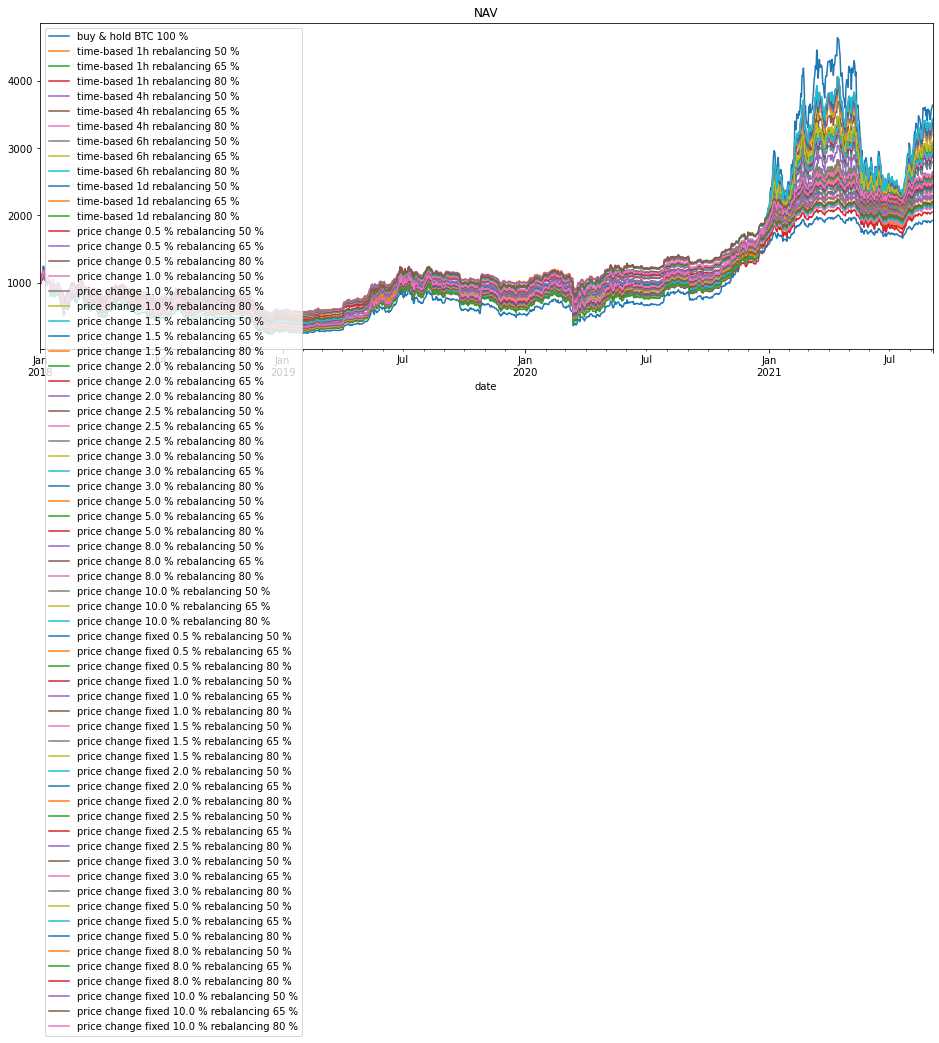

In [199]:
freqs = ('1h', '4h', '6h', '1d')
asset_ratios = (0.50, 0.65, 0.80)
# for asset_ratio in tqdm.tqdm(asset_ratios):
#     portfolio_price_df = buy_and_hold_by_ratio(price_df, asset_ratio=asset_ratio, capital=CAPITAL)
#     comparison_df[f'buy & hold BTC {int(asset_ratio*100)} %'] = portfolio_price_df['nav']

comparison_df[f'buy & hold BTC {100} %'] = buy_and_hold_by_ratio(price_df, asset_ratio=1.0, capital=CAPITAL)['nav']

params = list(itertools.product(freqs, asset_ratios))
for freq, asset_ratio in tqdm.tqdm(params):
    portfolio_df, portfolio_price_df = time_rebalance(price_df, frequency=freq, asset_ratio=asset_ratio, capital=CAPITAL)
    portfolio_name = f'time-based {freq} rebalancing {int(asset_ratio*100)} %'
    comparison_df[portfolio_name] = portfolio_price_df['nav']
    portfolios[portfolio_name] = portfolio_df
    portfolio_prices[portfolio_name] = portfolio_price_df
comparison_df = comparison_df.resample('1d').first()
comparison_df.plot(figsize=(16, 6), title='NAV')

Text(0.5, 0.98, 'NAV')

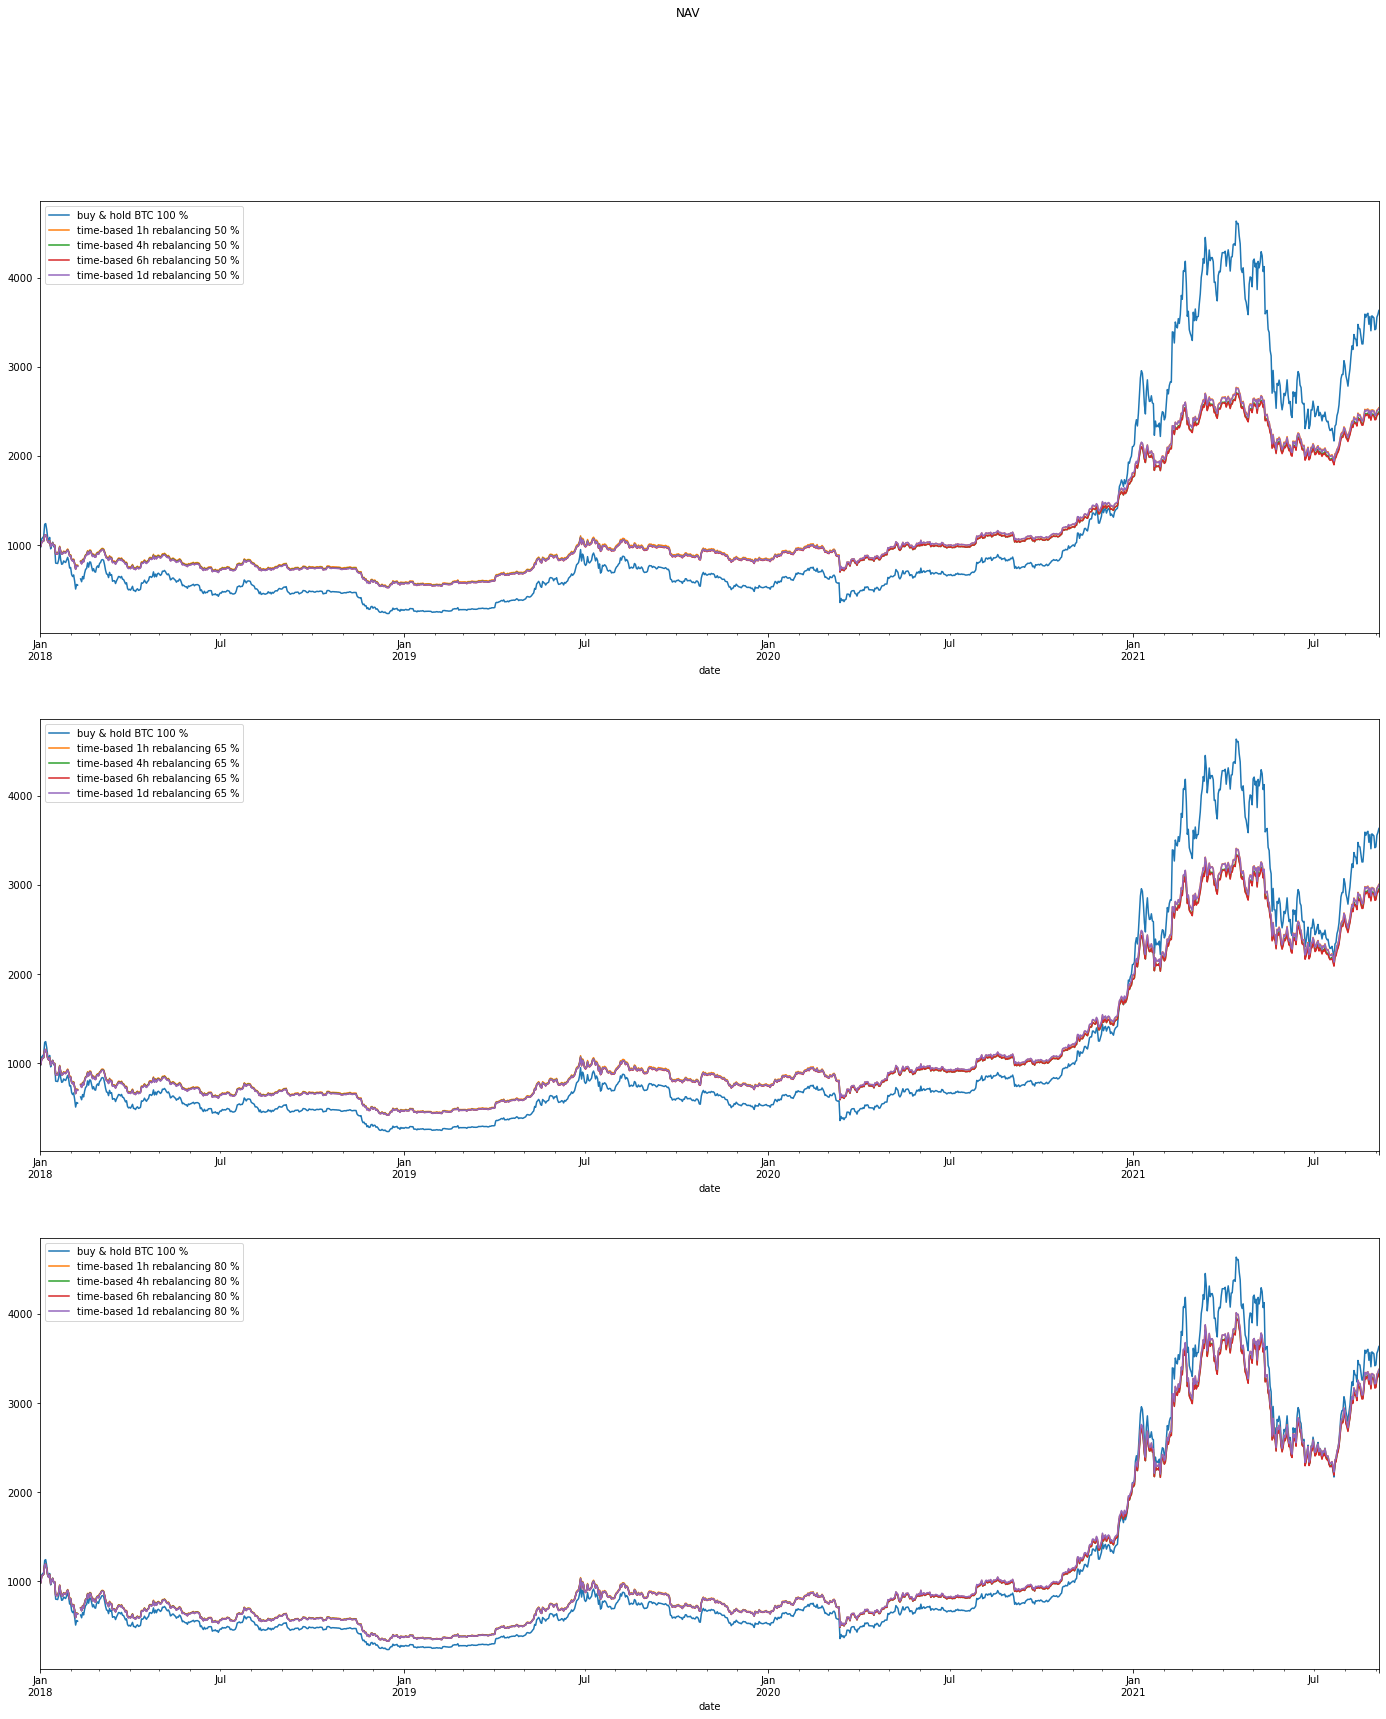

In [211]:
fig, axes = plt.subplots(nrows=len(asset_ratios), figsize=(24, 9*len(asset_ratios)))
for ax, asset_ratio in zip(axes, asset_ratios):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax)
    comparison_df.filter(regex=f'time-based .*{int(asset_ratio*100)} %.*').plot(ax=ax)
fig.suptitle('NAV')


Text(0.5, 0.98, 'NAV')

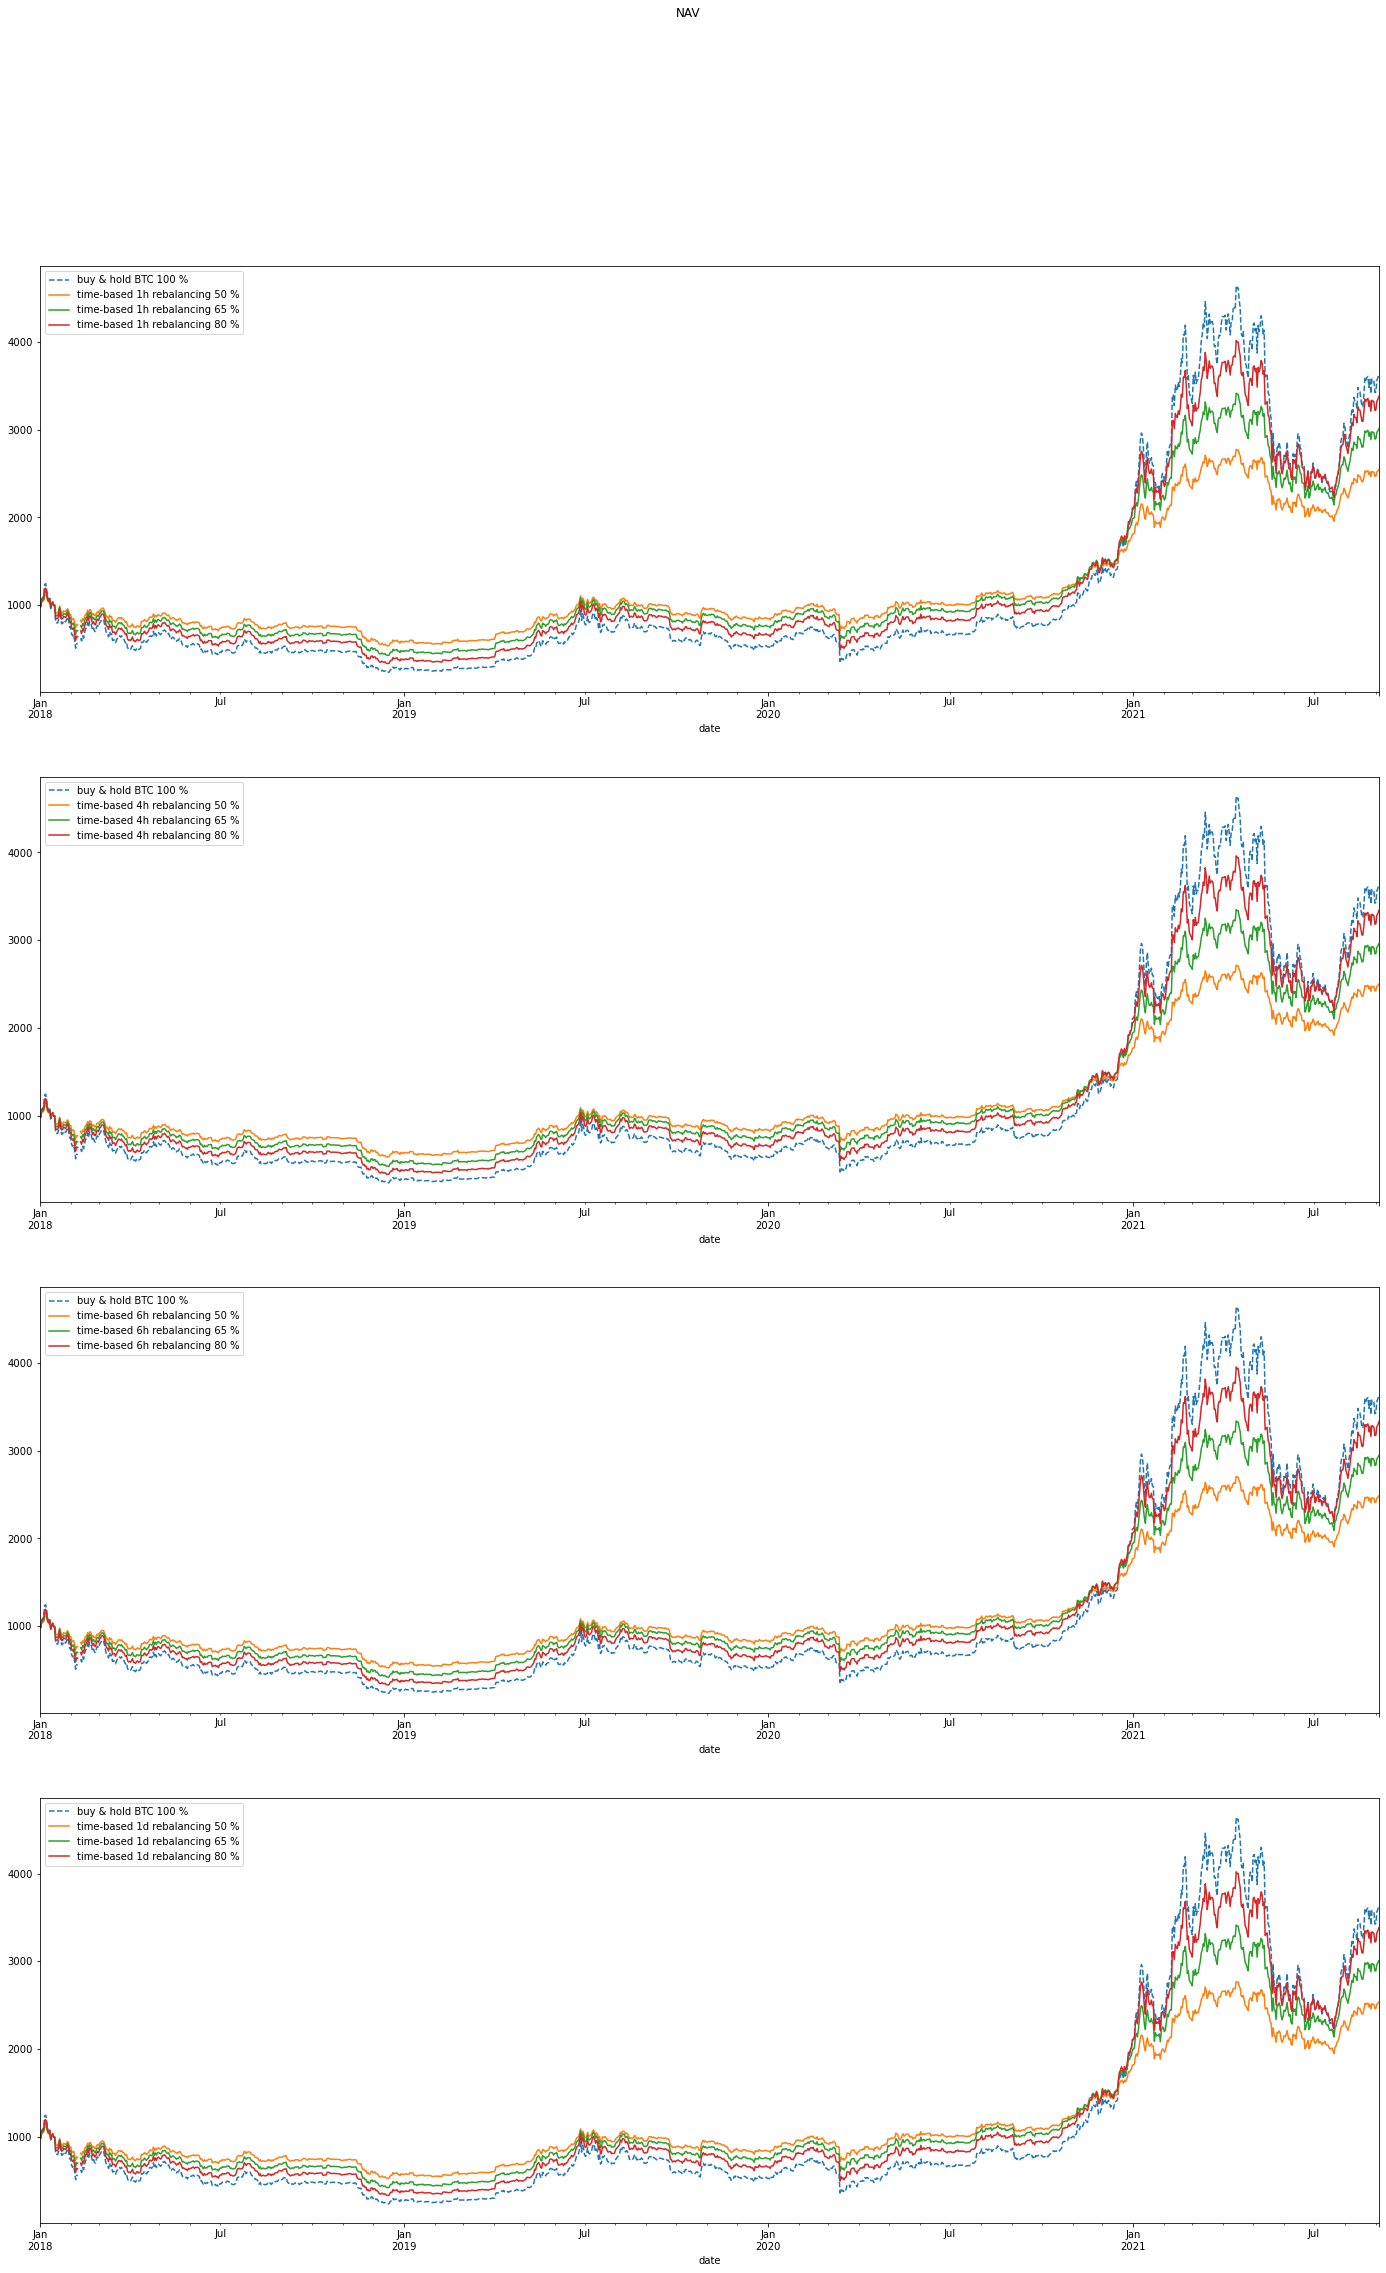

In [212]:
fig, axes = plt.subplots(nrows=len(freqs), figsize=(24, 9*len(freqs)))
for ax, freq in zip(axes, freqs):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'time-based .*{freq}.*').plot(ax=ax)
fig.suptitle('NAV')

In [213]:
efficient_frontier_df = pd.DataFrame(data={
    'return': comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': comparison_df.apply(volatility),
    'sharpe': comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
})

In [214]:
efficient_frontier_df.style.background_gradient(axis=0,)


### Price-based Rebalancing

In [58]:
def generate_price_trigger(price_df, price_rebalance_ratio):
    init_price = price_df['close'].iloc[0]

    trigger_data = []
    current_position_price = init_price
    for dt, price in zip(price_df.index.values, price_df['close'].values):

        while True:
            upper_next_position_price = current_position_price * (1 + price_rebalance_ratio)
            lower_next_position_price = current_position_price * (1 - price_rebalance_ratio)

            if price > upper_next_position_price:
                current_position_price = upper_next_position_price
            elif price < lower_next_position_price:
                current_position_price = lower_next_position_price
            else:
                break

            trigger_data.append({
                'date': dt,
                'price': current_position_price
            })

    trigger_df = pd.DataFrame(trigger_data)
    return trigger_df

price_rebalance_ratio = 0.1
trigger_df = generate_price_trigger(price_df, price_rebalance_ratio)
trigger_df

date         price
0   2018-01-02 19:19:00  15078.712000
1   2018-01-05 17:24:00  16586.583200
2   2018-01-08 09:30:00  14927.924880
3   2018-01-08 14:49:00  13435.132392
4   2018-01-08 16:48:00  14778.645631
..                  ...           ...
248 2021-07-21 16:36:00  32257.457492
249 2021-07-26 00:12:00  35483.203241
250 2021-07-26 01:01:00  39031.523566
251 2021-08-06 16:10:00  42934.675922
252 2021-08-13 20:06:00  47228.143514

[253 rows x 2 columns]

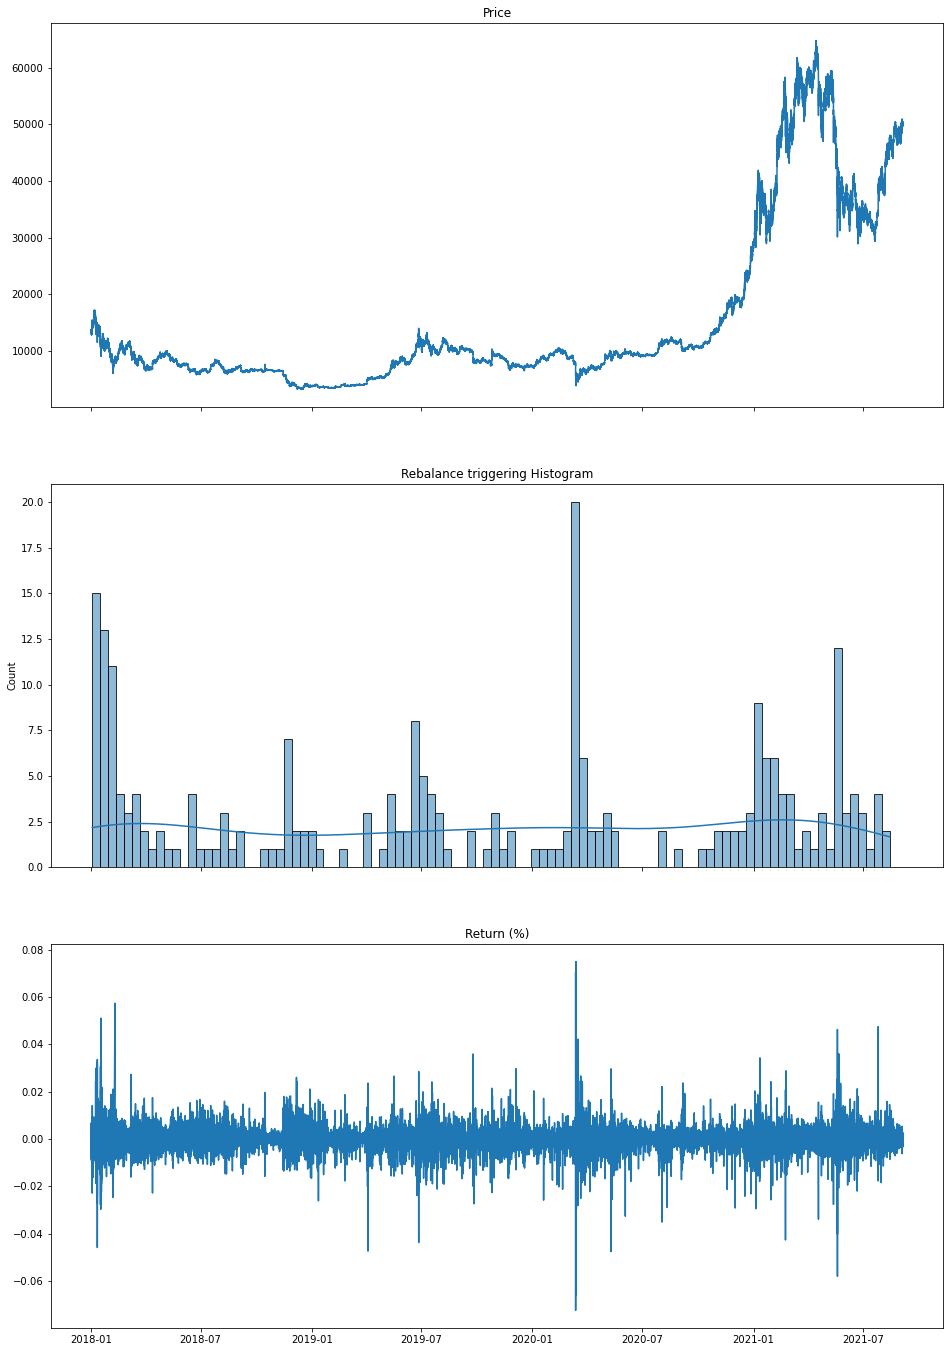

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(16, 24))

ax1.set_title('Price')
ax1.plot(price_df.index, price_df['close'])
ax2.set_title('Rebalance triggering Histogram')
sns.histplot(trigger_df, x='date', bins=100, kde=True, ax=ax2)
ax3.set_title('Return (%)')
ax3.plot(price_df.index, price_df['close'].pct_change())

In [60]:
def price_rebalance(price_df, price_rebalance_ratio, asset_ratio, capital, fix_asset=False):
    trigger_df = generate_price_trigger(price_df, price_rebalance_ratio)
    
    if fix_asset:
        return simulate_fixed_asset_rebalancing(price_df, trigger_df, asset_ratio, capital)
    else:
        return simulate_rebalancing(price_df, trigger_df, asset_ratio, capital)


In [61]:
portfolio_df, portfolio_price_df = price_rebalance(price_df, price_rebalance_ratio=0.2, asset_ratio=0.70, capital=CAPITAL)

In [62]:
portfolio_df

nav  asset_value  asset_amount        cash  \
date                                                                      
2018-01-01 00:00:00  1000.000000   700.000000      0.051065  300.000000   
2018-01-05 16:27:00  1000.000000   700.000000      0.051065  300.000000   
2018-01-08 15:05:00  1139.970600   798.000000      0.048512  341.970600   
2018-01-16 21:02:00   980.337098   686.259420      0.052149  294.077678   
2018-01-20 05:38:00   843.056408   590.159650      0.056058  252.896758   
...                          ...          ...           ...         ...   
2021-06-08 15:21:00  2762.412428  1933.738600      0.049620  828.673829   
2021-06-09 23:29:00  2375.583526  1662.965296      0.053340  712.618230   
2021-06-22 12:25:00  2708.106701  1895.723610      0.050671  812.383091   
2021-06-29 12:46:00  2328.882393  1630.273385      0.054470  698.609008   
2021-08-06 17:44:00  2654.868560  1858.455949      0.051745  796.412611   

                            price action  position_value  \
date                                                       
2018-01-01 00:00:00           NaN    NaN             NaN   
2018-01-05 16:27:00  16449.504000   Sell      -42.000000   
2018-01-08 15:05:00  13159.603200    Buy       47.859420   
2018-01-16 21:02:00  10527.682560    Buy       41.152114   
2018-01-20 05:38:00  12633.219072   Sell      -35.429744   
...                           ...    ...             ...   
2021-06-08 15:21:00  31176.763310    Buy      115.974416   
2021-06-09 23:29:00  37412.115972   Sell      -99.834745   
2021-06-22 12:25:00  29929.692778    Buy      113.694498   
2021-06-29 12:46:00  35915.631333   Sell      -97.872113   
2021-08-06 17:44:00  43098.757600   Sell     -111.555314   

                     posterior_asset_value  posterior_asset_amount  \
date                                                                 
2018-01-01 00:00:00                    NaN                     NaN   
2018-01-05 16:27:00             798.000000                0.048512   
2018-01-08 15:05:00             686.259420                0.052149   
2018-01-16 21:02:00             590.159650                0.056058   
2018-01-20 05:38:00             672.761837                0.053253   
...                                    ...                     ...   
2021-06-08 15:21:00            1662.965296                0.053340   
2021-06-09 23:29:00            1895.723610                0.050671   
2021-06-22 12:25:00            1630.273385                0.054470   
2021-06-29 12:46:00            1858.455949                0.051745   
2021-08-06 17:44:00            2118.591825                0.049157   

                     posterior_cash  posterior_nav  
date                                                
2018-01-01 00:00:00             NaN            NaN  
2018-01-05 16:27:00      341.970600    1139.970600  
2018-01-08 15:05:00      294.077678     980.337098  
2018-01-16 21:02:00      252.896758     843.056408  
2018-01-20 05:38:00      288.301701     961.063537  
...                             ...            ...  
2021-06-08 15:21:00      712.618230    2375.583526  
2021-06-09 23:29:00      812.383091    2708.106701  
2021-06-22 12:25:00      698.609008    2328.882393  
2021-06-29 12:46:00      796.412611    2654.868560  
2021-08-06 17:44:00      907.889836    3026.481661  

[74 rows x 11 columns]

100%|██████████| 27/27 [01:30<00:00,  3.34s/it]


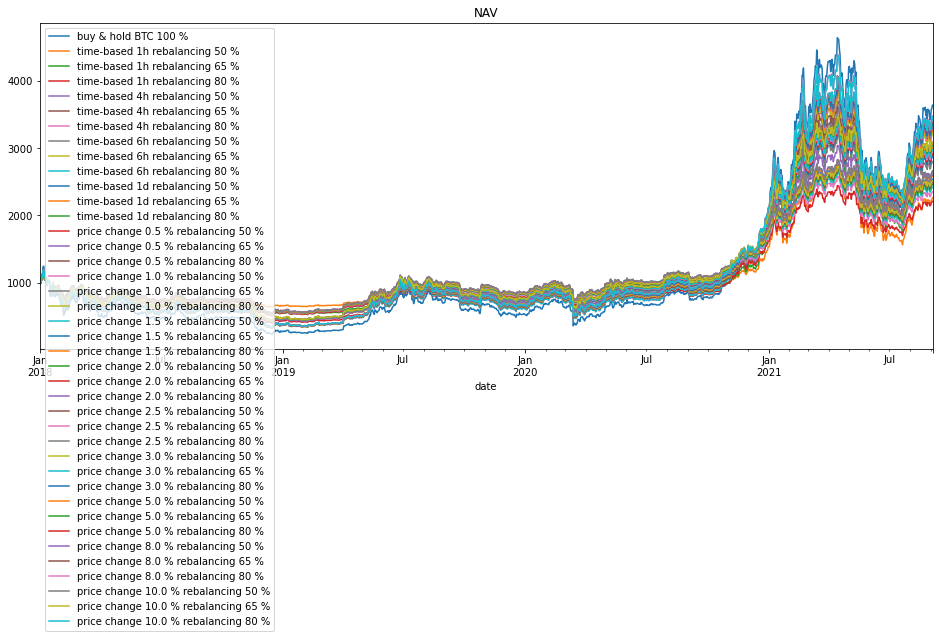

In [80]:

price_change_percentages = (0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 5.00, 8.00, 10.00) 
asset_ratios = (0.50, 0.65, 0.80)

# for asset_ratio in tqdm.tqdm(asset_ratios):
#     portfolio_price_df = buy_and_hold_by_ratio(price_df, asset_ratio=asset_ratio, capital=CAPITAL)
#     comparison_df[f'buy & hold BTC {int(asset_ratio*100)} %'] = portfolio_price_df['nav']

params = list(itertools.product(price_change_percentages, asset_ratios))
for percent, asset_ratio in tqdm.tqdm(params):
    portfolio_df, portfolio_price_df = price_rebalance(price_df,
                                                       price_rebalance_ratio=percent/100,
                                                       asset_ratio=asset_ratio,
                                                       capital=CAPITAL)
    portfolio_name = f'price change {percent} % rebalancing {int(asset_ratio*100)} %'
    
    comparison_df[portfolio_name] = portfolio_price_df['nav']
    portfolios[portfolio_name] = portfolio_df
    portfolio_prices[portfolio_name] = portfolio_price_df
comparison_df = comparison_df.resample('1d').first()
comparison_df.plot(figsize=(16, 6), title='NAV')

Text(0.5, 0.98, 'NAV')

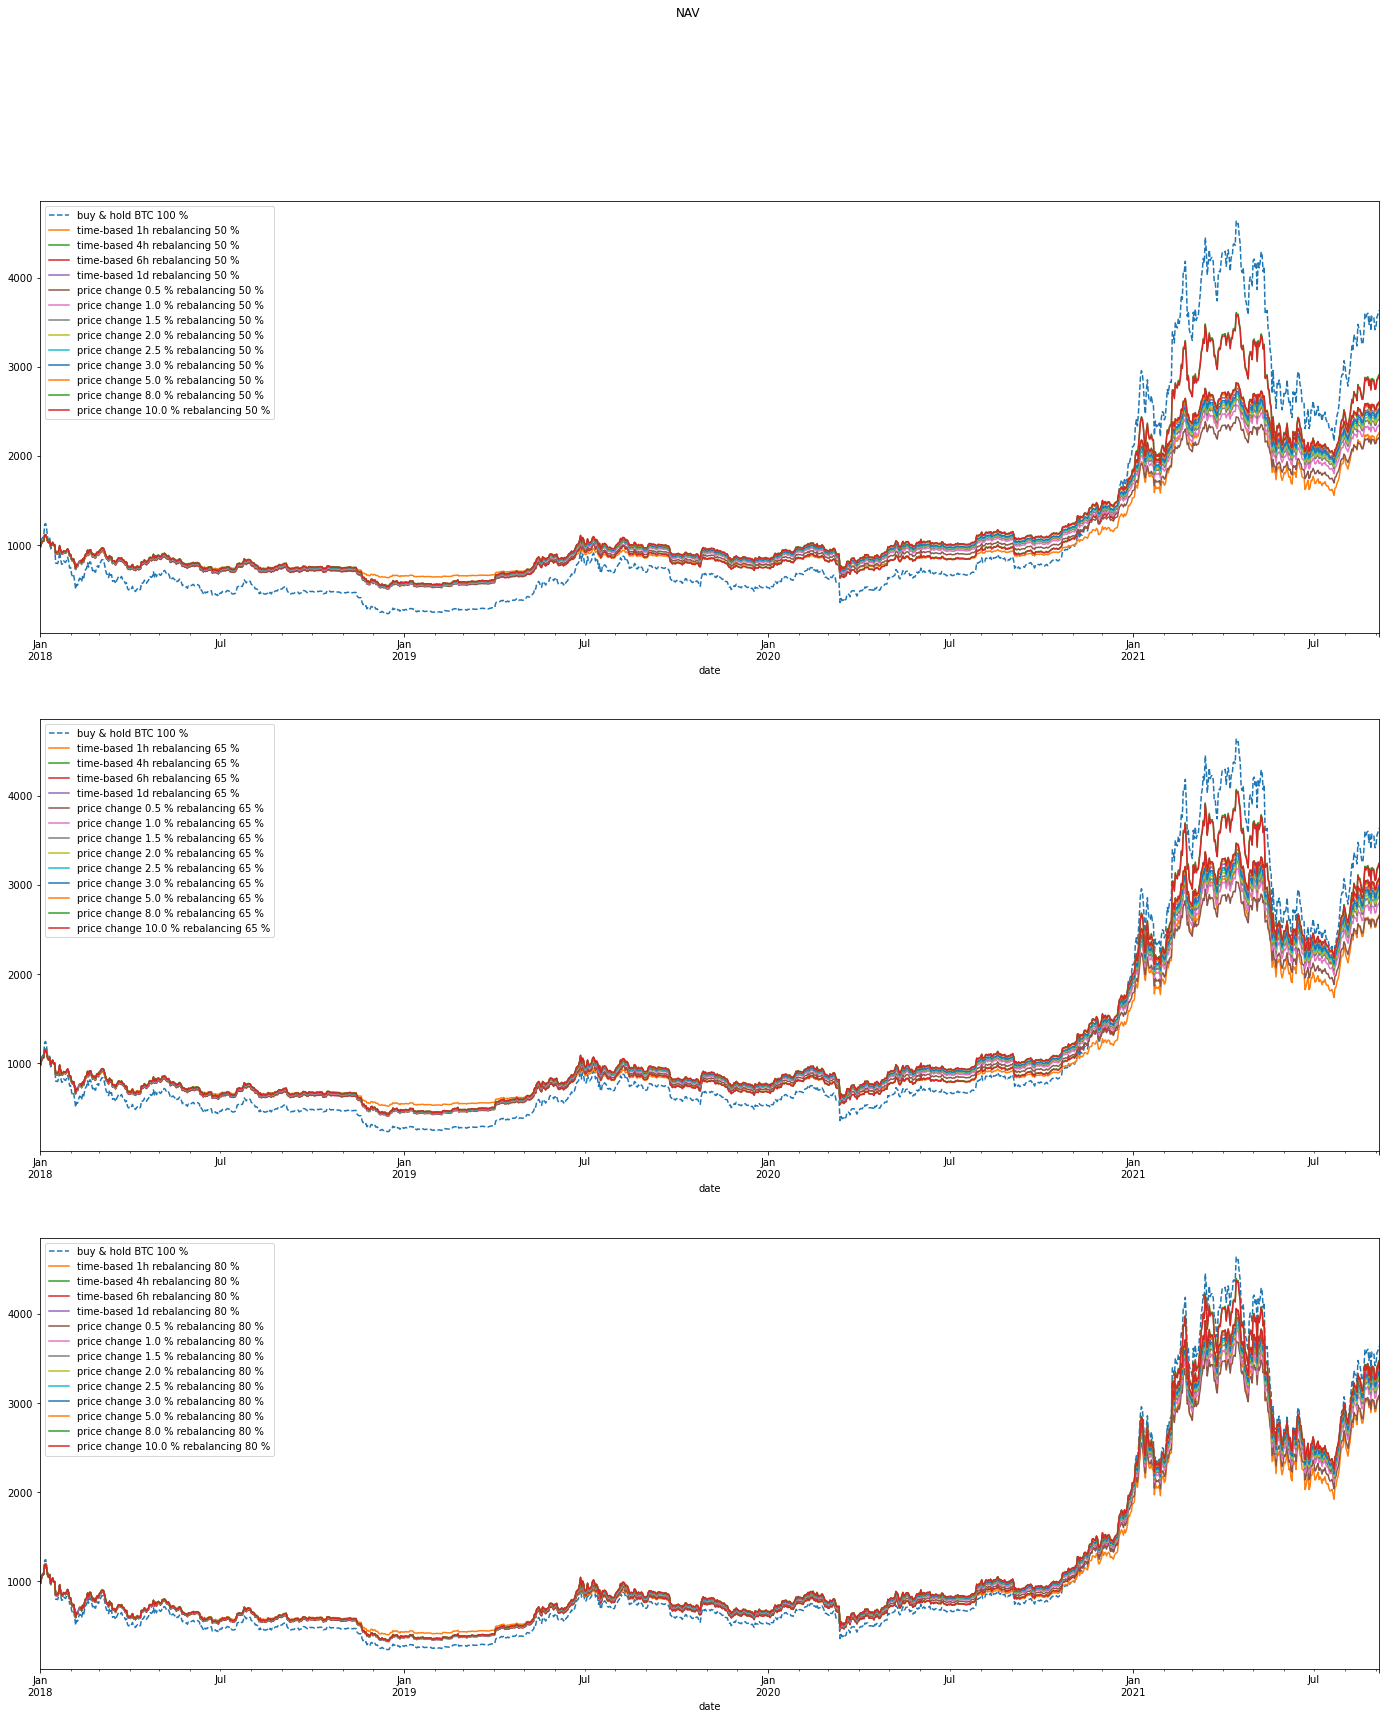

In [64]:
fig, axes = plt.subplots(nrows=len(asset_ratios), figsize=(24, 9*len(asset_ratios)))
for ax, asset_ratio in zip(axes, asset_ratios):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'.*rebalancing {int(asset_ratio*100)} %.*').plot(ax=ax)
fig.suptitle('NAV')


Text(0.5, 0.98, 'NAV')

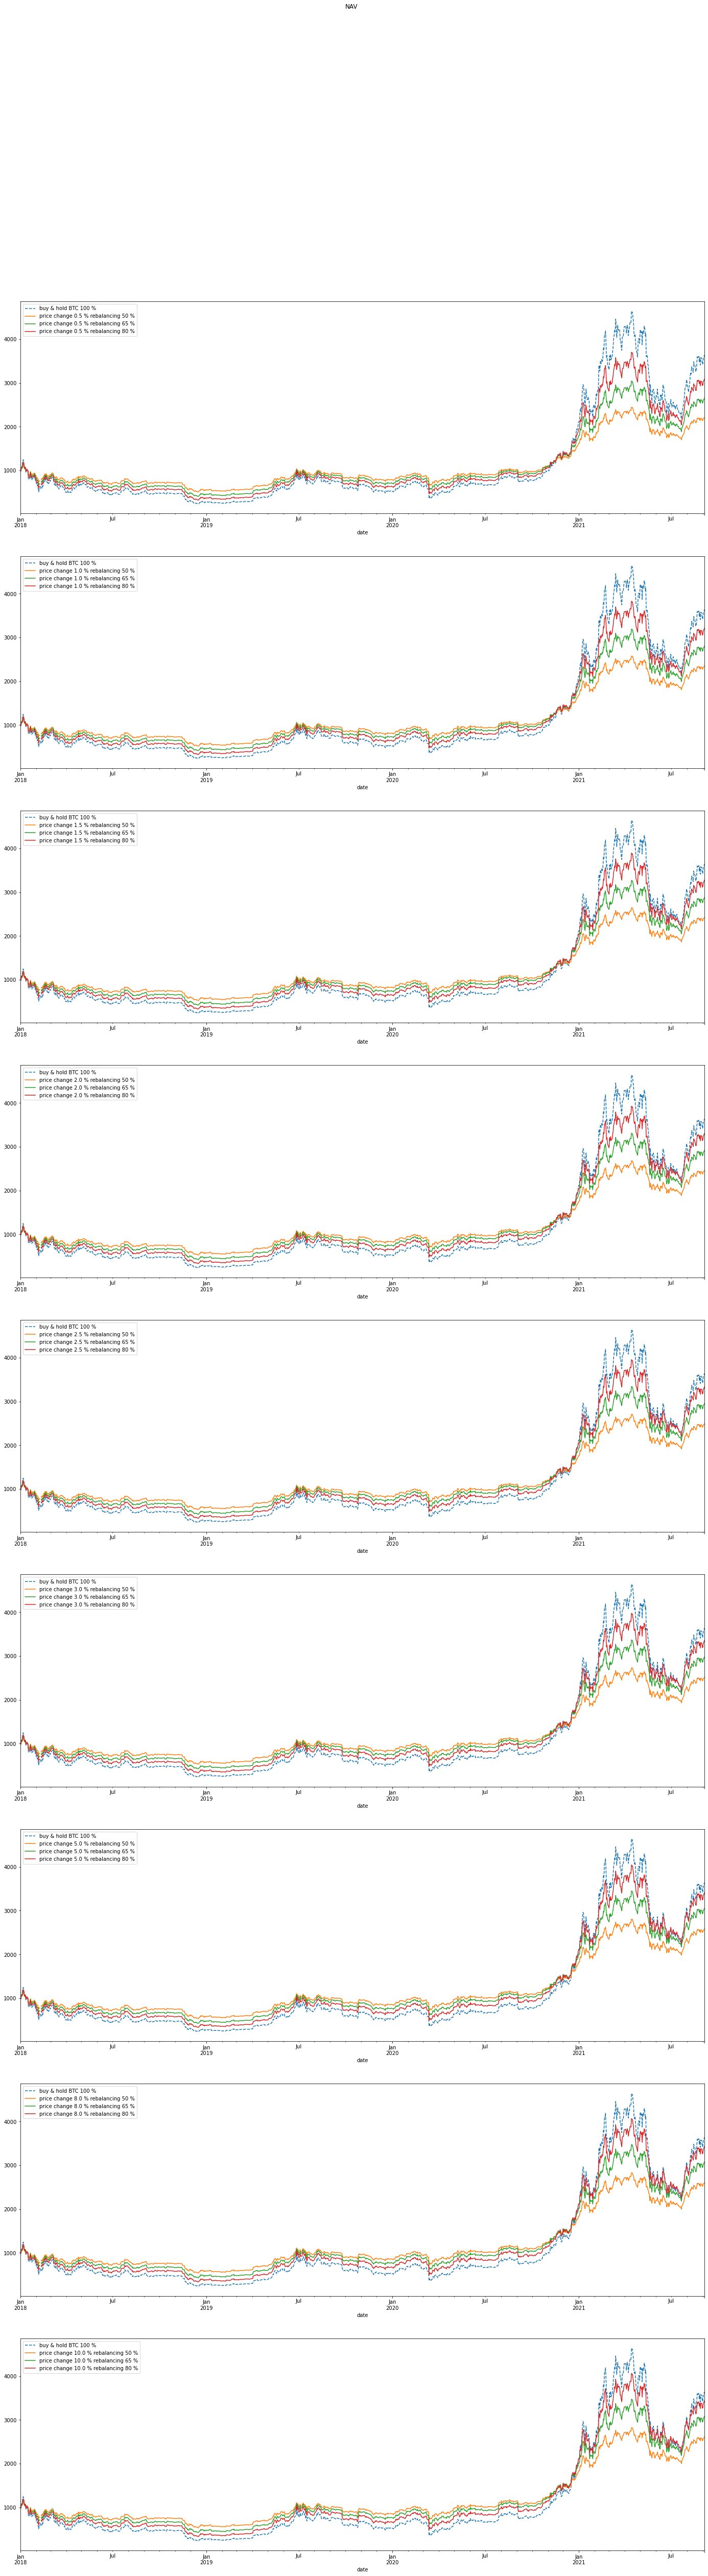

In [65]:
fig, axes = plt.subplots(nrows=len(price_change_percentages), figsize=(24, 9*len(price_change_percentages)))
for ax, percent in zip(axes, price_change_percentages):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'.*price change {percent:.1f} %.*').plot(ax=ax)
    
fig.suptitle('NAV')

In [66]:
# rebalance_comparison_df = comparison_df.filter(regex='.*rebalancing.*')
rebalance_comparison_df = comparison_df.resample('1d').first()
efficient_frontier_df = pd.DataFrame(data={
    'number of order': pd.Series(portfolios).map(len),
    'return': rebalance_comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': rebalance_comparison_df.apply(volatility),
    'sharpe': rebalance_comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
    'max_drawdown': rebalance_comparison_df.apply(max_drawdown),
}).fillna({'number of order': 0})
efficient_frontier_df.style.background_gradient(axis=0,)


### Price-based + Fixed asset Rebalancing

100%|██████████| 27/27 [01:33<00:00,  3.46s/it]


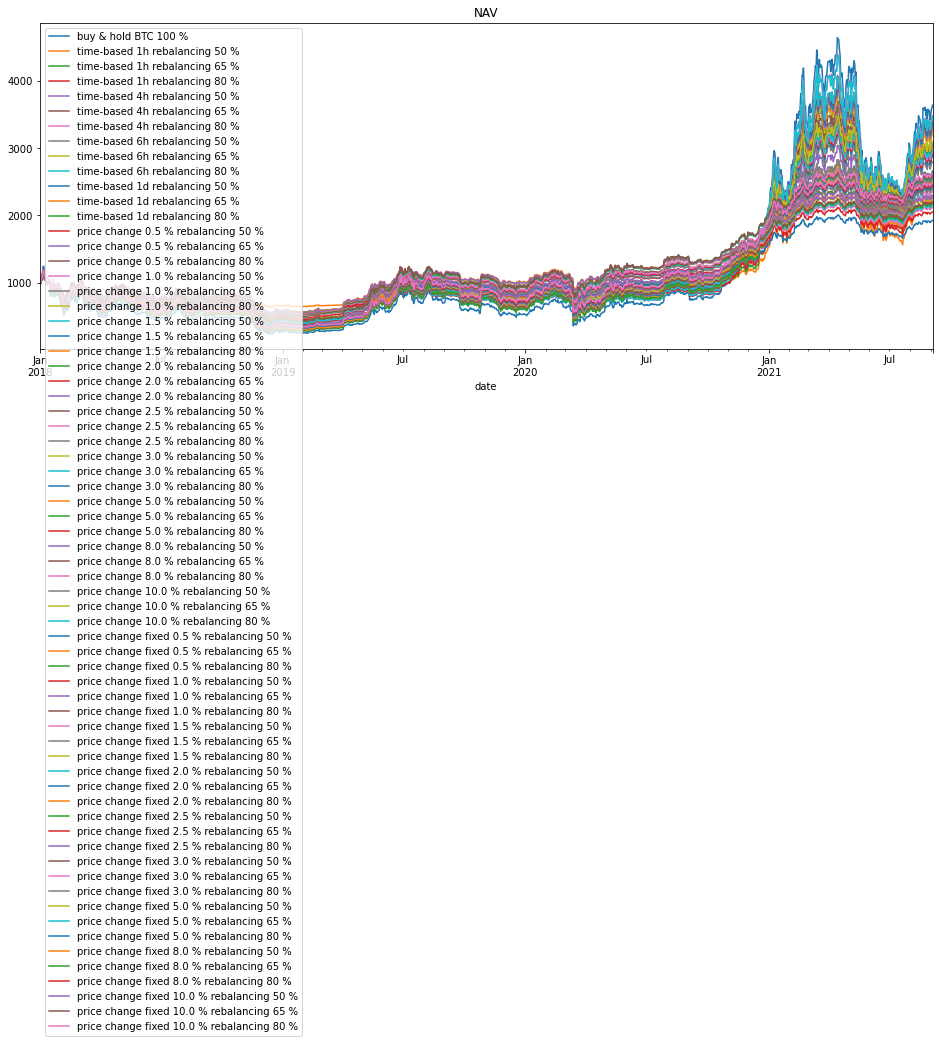

In [81]:
price_change_percentages = (0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 5.00, 8.00, 10.00) 
asset_ratios = (0.50, 0.65, 0.80)

params = list(itertools.product(price_change_percentages, asset_ratios))
for percent, asset_ratio in tqdm.tqdm(params):
    portfolio_df, portfolio_price_df = price_rebalance(price_df,
                                                       price_rebalance_ratio=percent/100,
                                                       asset_ratio=asset_ratio,
                                                       capital=CAPITAL,
                                                       fix_asset=True
                                                      )
    portfolio_name = f'price change fixed {percent} % rebalancing {int(asset_ratio*100)} %'
    
    comparison_df[portfolio_name] = portfolio_price_df['nav']
    portfolios[portfolio_name] = portfolio_df
    portfolio_prices[portfolio_name] = portfolio_price_df
    
comparison_df = comparison_df.resample('1d').first()

comparison_df.plot(figsize=(16, 6), title='NAV')

Text(0.5, 0.98, 'NAV')

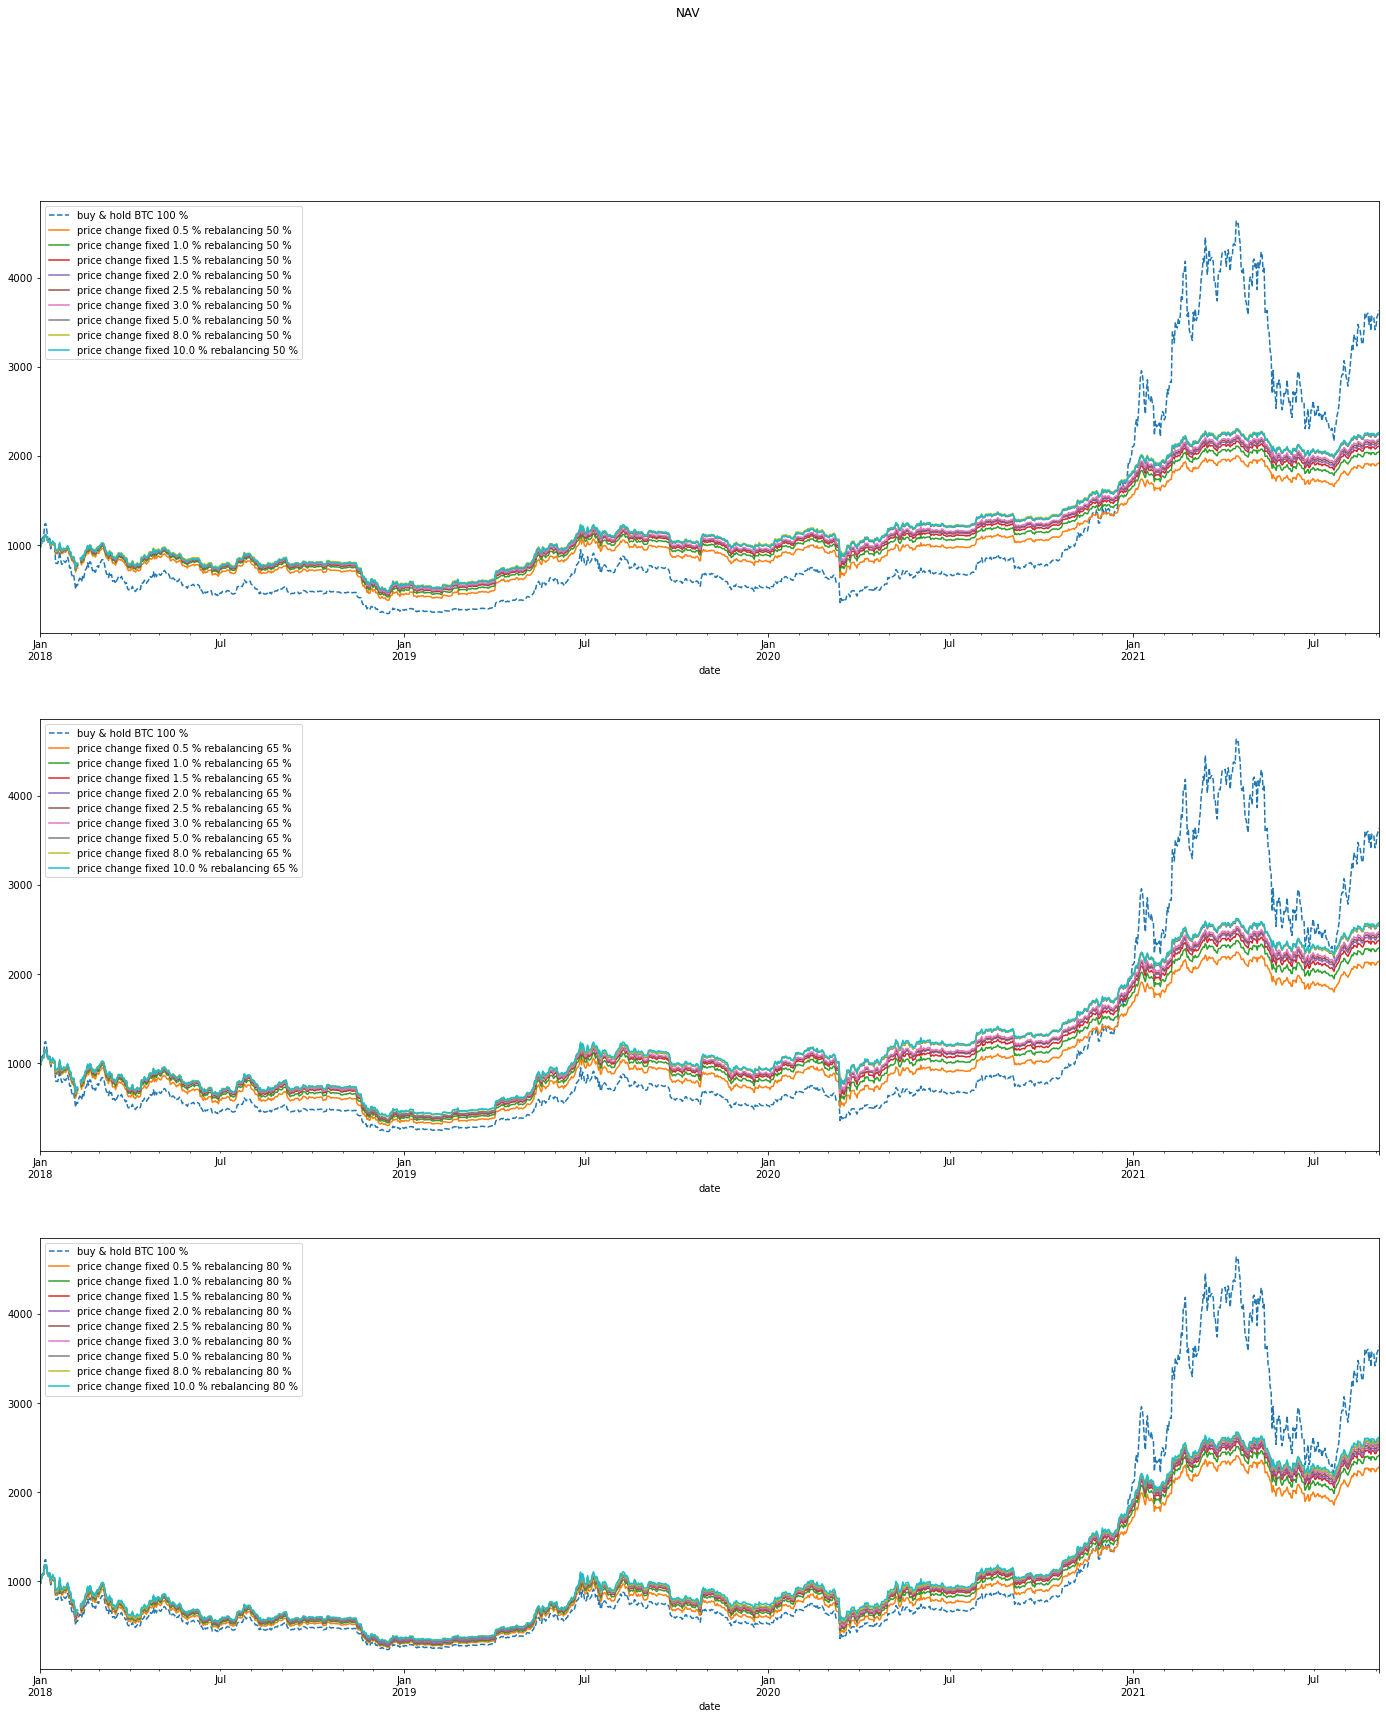

In [68]:
fig, axes = plt.subplots(nrows=len(asset_ratios), figsize=(24, 9*len(asset_ratios)))
for ax, asset_ratio in zip(axes, asset_ratios):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'.*fixed.*rebalancing {int(asset_ratio*100)} %.*').plot(ax=ax)
fig.suptitle('NAV')


Text(0.5, 0.98, 'NAV')

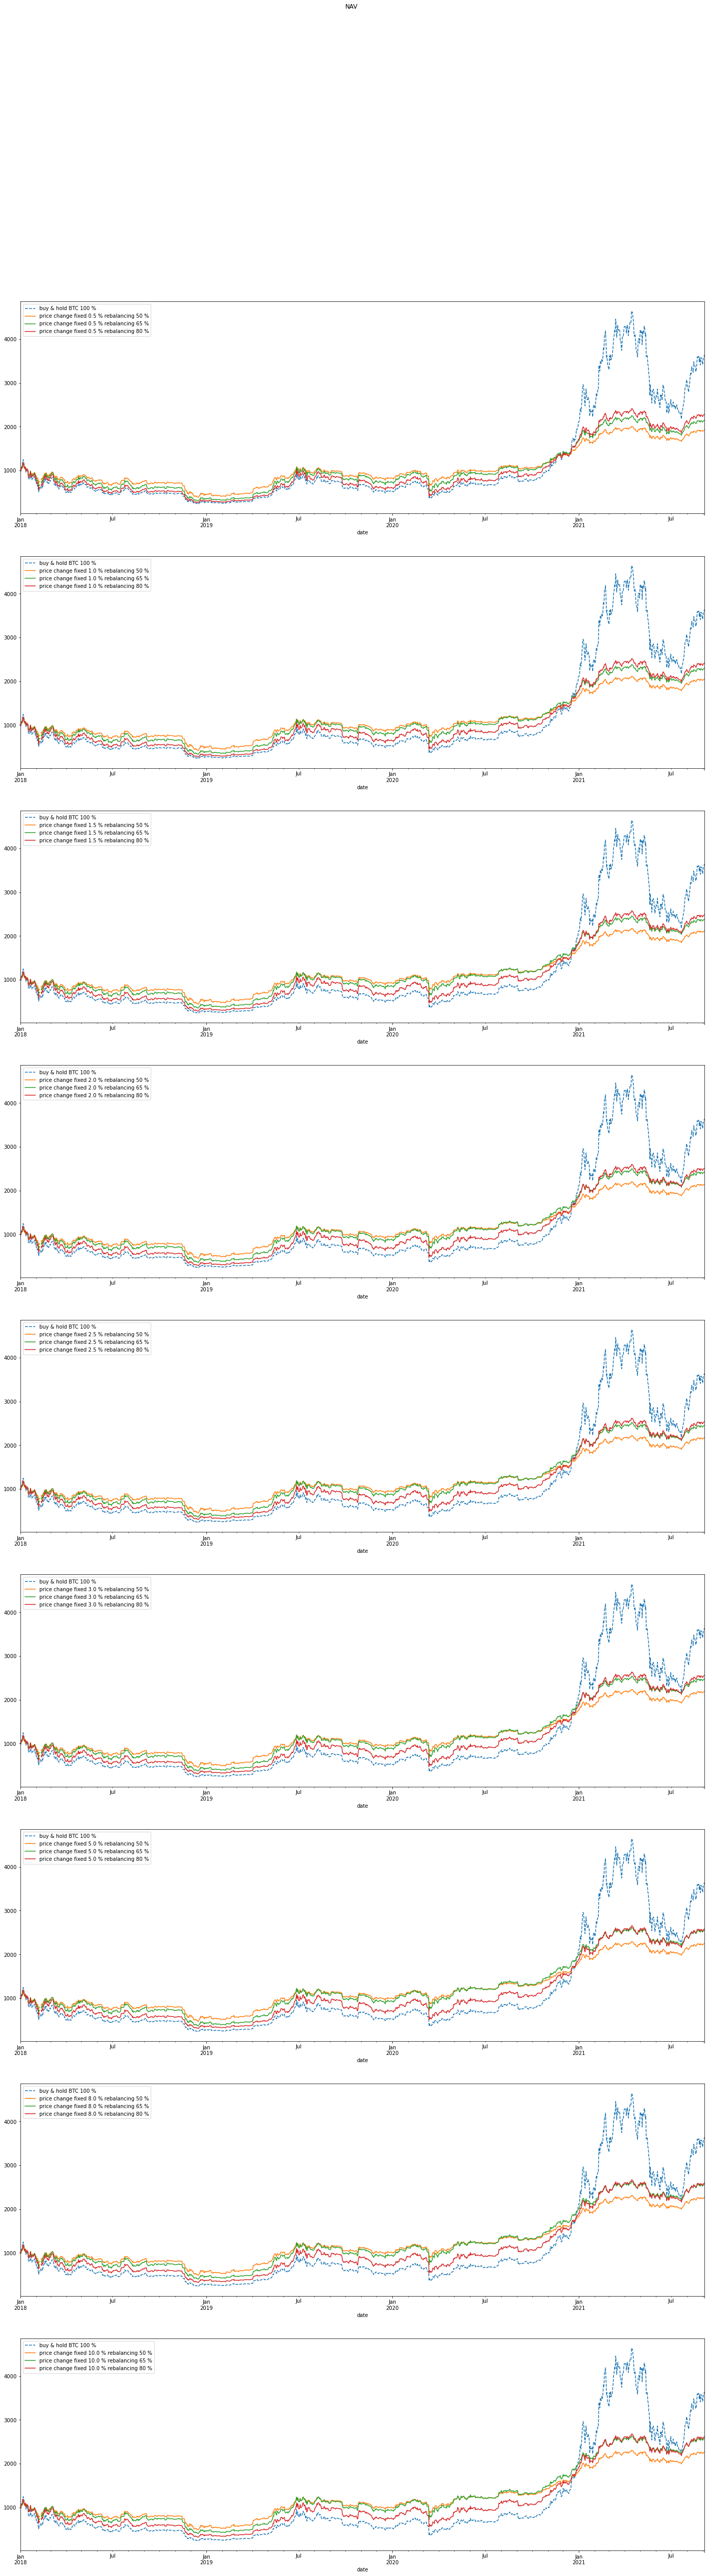

In [69]:
fig, axes = plt.subplots(nrows=len(price_change_percentages), figsize=(24, 9*len(price_change_percentages)))
for ax, percent in zip(axes, price_change_percentages):
    comparison_df.filter(regex=f'.*BTC.*').plot(ax=ax, linestyle='dashed')
    comparison_df.filter(regex=f'.*price change fixed {percent:.1f} %.*').plot(ax=ax)
    
fig.suptitle('NAV')

# Model Interpretation

## Time-based Rebalancing

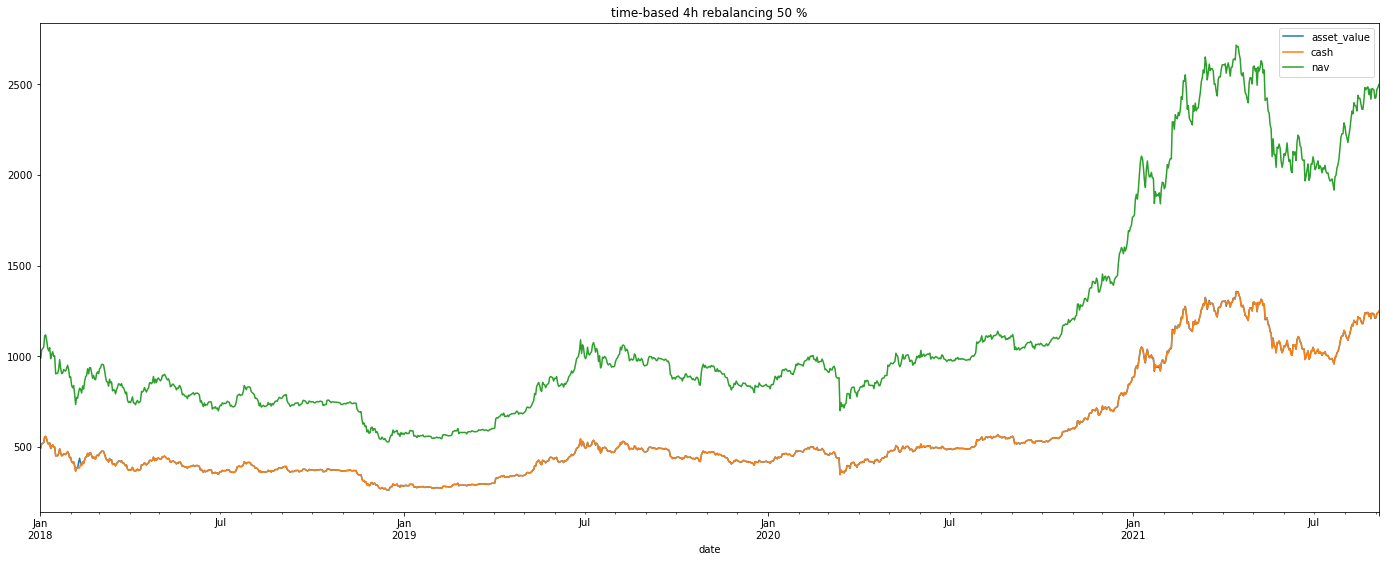

In [215]:
portfolio_name = 'time-based 4h rebalancing 50 %'
portfolio_price_df = portfolio_prices[portfolio_name].resample('1d').first()
portfolio_price_df.plot(y=['asset_value', 'cash', 'nav'], figsize=(24, 9), title=portfolio_name)

## Price-based Rebalancing

lean to market trend


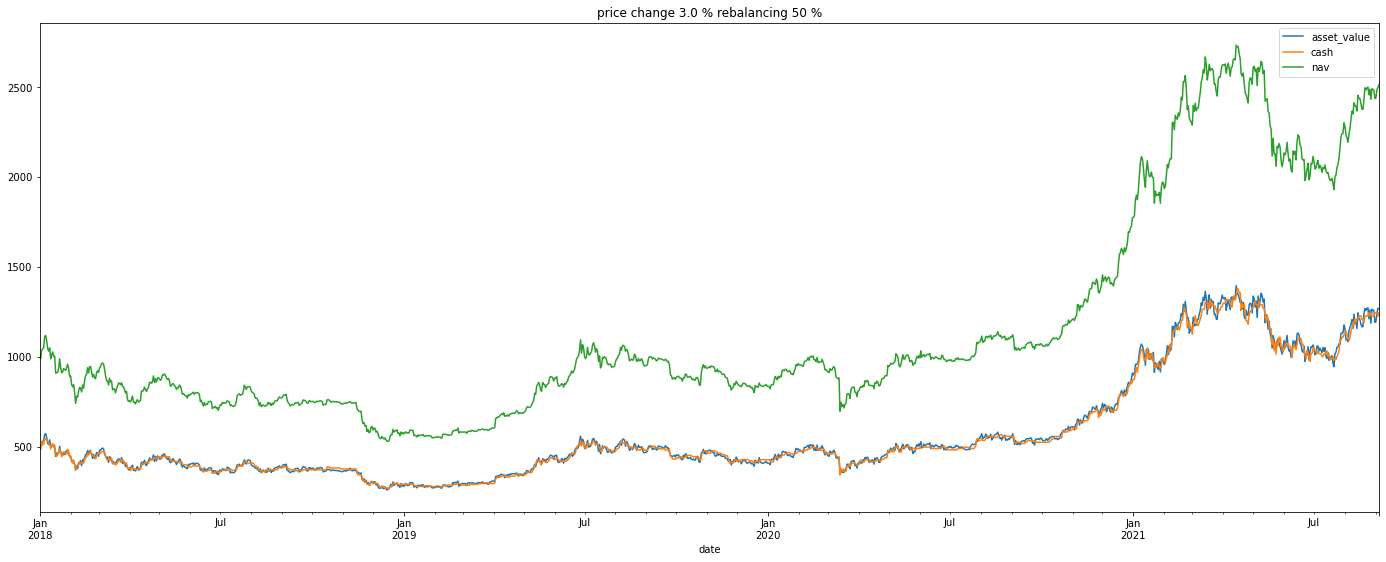

In [216]:
portfolio_name = 'price change 3.0 % rebalancing 50 %'
portfolio_price_df = portfolio_prices[portfolio_name].resample('1d').first()
portfolio_price_df.plot(y=['asset_value', 'cash', 'nav'], figsize=(24, 9), title=portfolio_name)

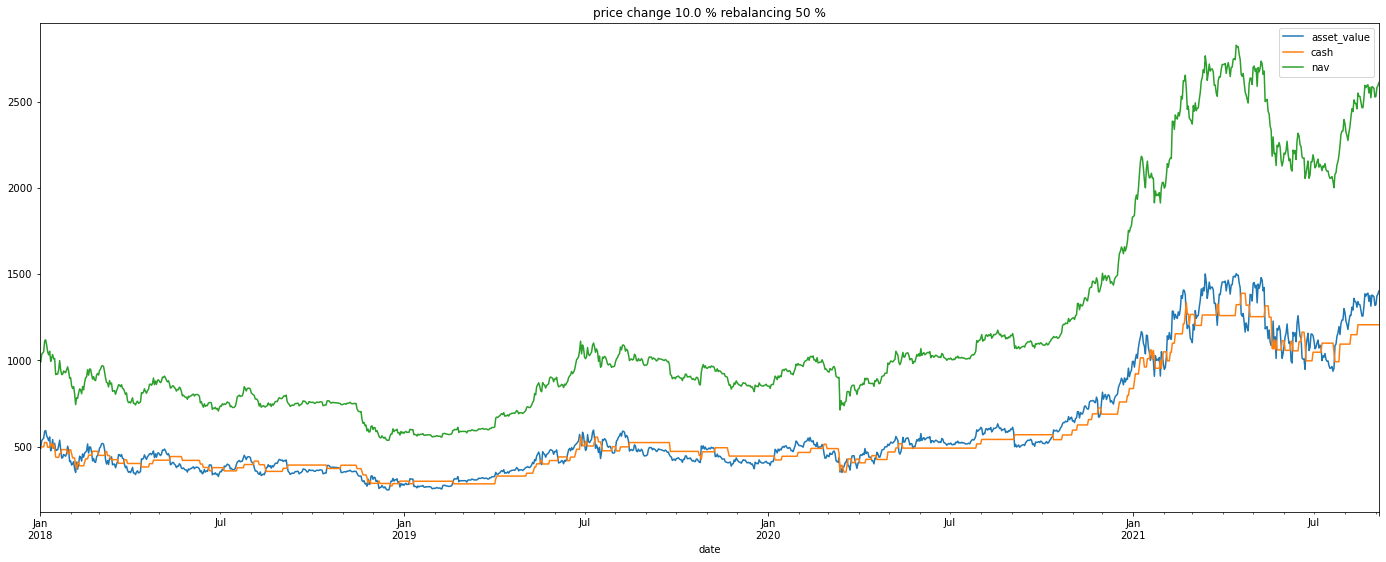

In [217]:
portfolio_name = 'price change 10.0 % rebalancing 50 %'
portfolio_price_df = portfolio_prices[portfolio_name].resample('1d').first()
portfolio_price_df.plot(y=['asset_value', 'cash', 'nav'], figsize=(24, 9), title=portfolio_name)

## Price-based + Fixed asset Rebalancing

Possible to lose all money

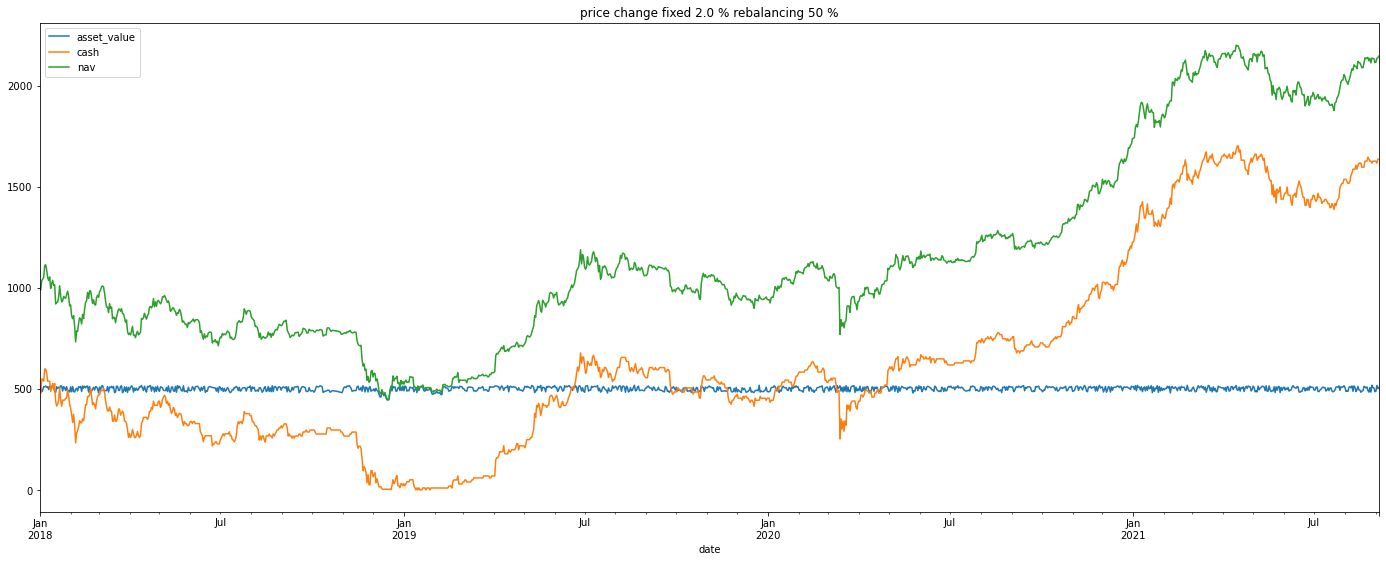

In [154]:
portfolio_name = 'price change fixed 2.0 % rebalancing 50 %'
portfolio_price_df = portfolio_prices[portfolio_name].resample('1d').first()
portfolio_price_df.plot(y=['asset_value', 'cash', 'nav'], figsize=(24, 9), title=portfolio_name)

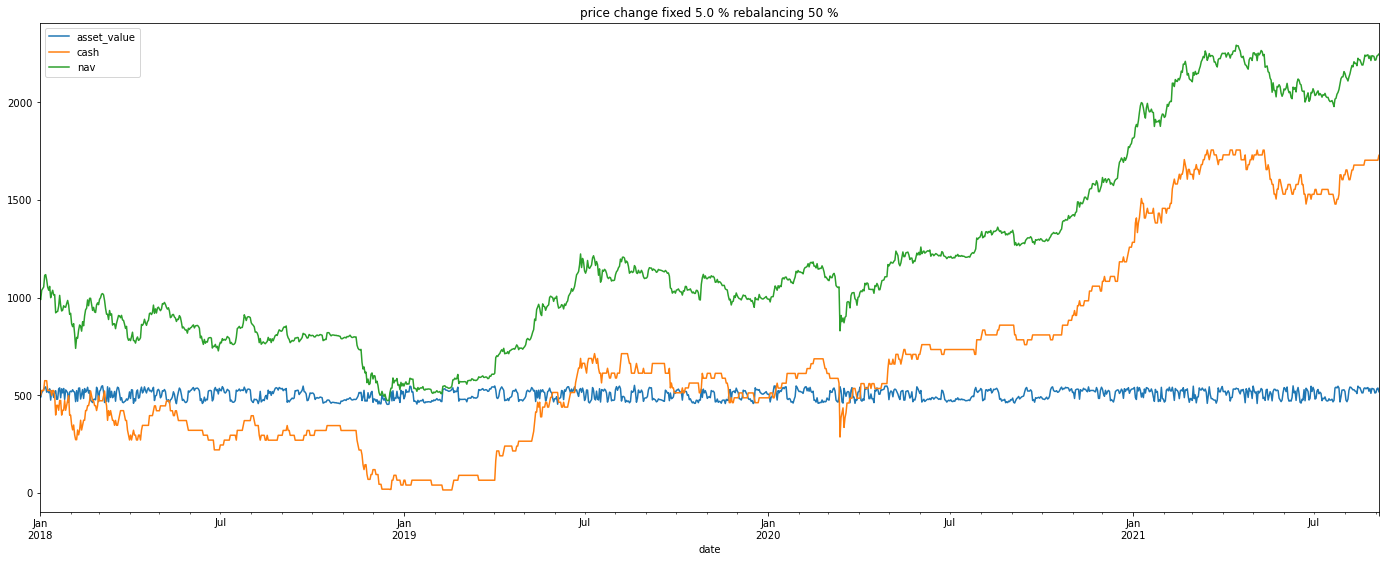

In [155]:
portfolio_name = 'price change fixed 5.0 % rebalancing 50 %'
portfolio_price_df = portfolio_prices[portfolio_name].resample('1d').first()
portfolio_price_df.plot(y=['asset_value', 'cash', 'nav'], figsize=(24, 9), title=portfolio_name)

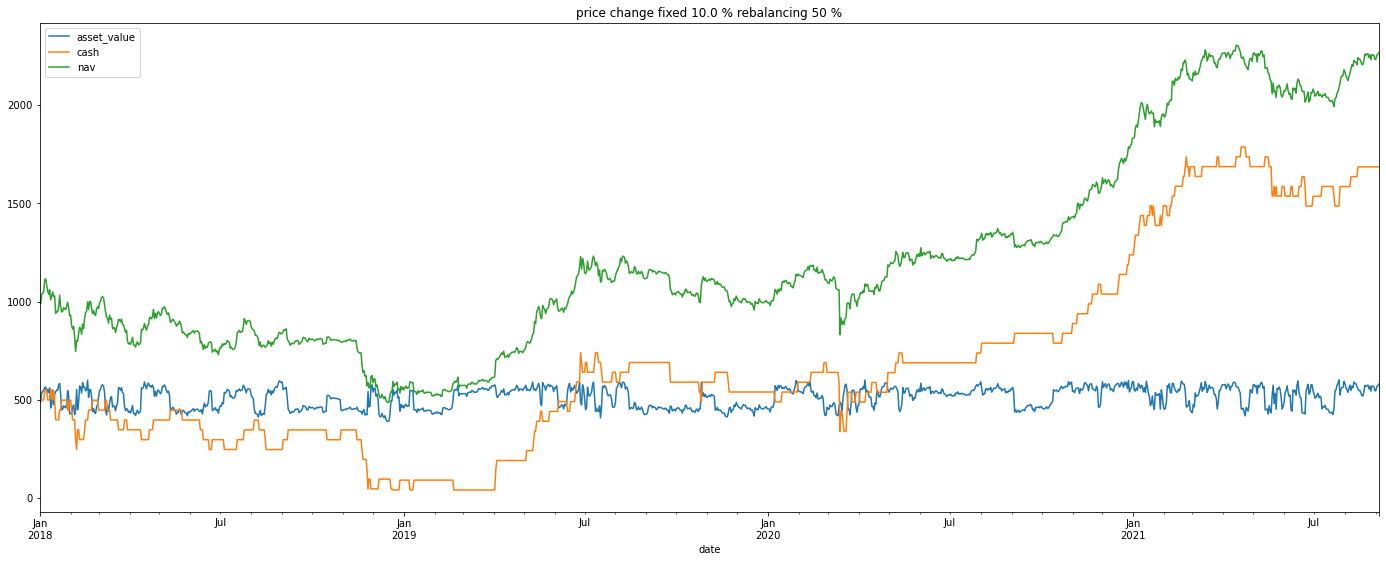

In [156]:
portfolio_name = 'price change fixed 10.0 % rebalancing 50 %'
portfolio_price_df = portfolio_prices[portfolio_name].resample('1d').first()
portfolio_price_df.plot(y=['asset_value', 'cash', 'nav'], figsize=(24, 9), title=portfolio_name)

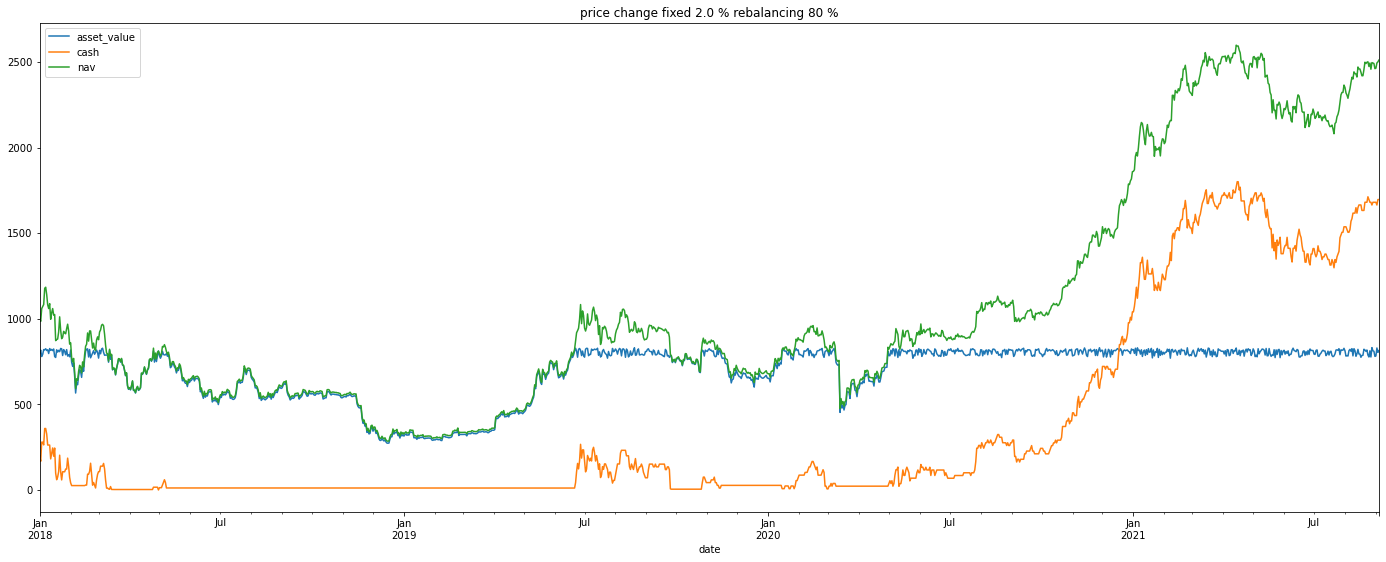

In [157]:
portfolio_name = 'price change fixed 2.0 % rebalancing 80 %'
portfolio_price_df = portfolio_prices[portfolio_name].resample('1d').first()
portfolio_price_df.plot(y=['asset_value', 'cash', 'nav'], figsize=(24, 9), title=portfolio_name)

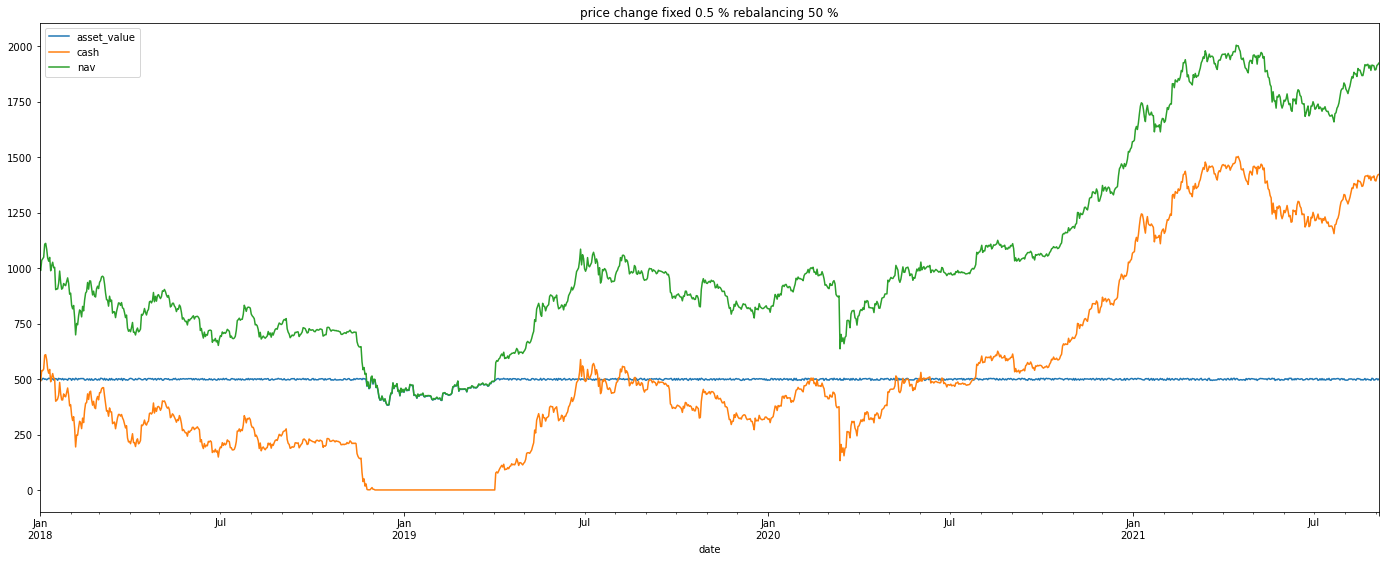

In [158]:
portfolio_name = 'price change fixed 0.5 % rebalancing 50 %'
portfolio_price_df = portfolio_prices[portfolio_name].resample('1d').first()
portfolio_price_df.plot(y=['asset_value', 'cash', 'nav'], figsize=(24, 9), title=portfolio_name)

In [70]:
# rebalance_comparison_df = comparison_df.filter(regex='.*rebalancing.*')
rebalance_comparison_df = comparison_df.resample('1d').first()
efficient_frontier_df = pd.DataFrame(data={
    'number of order': pd.Series(portfolios).map(len),
    'return': rebalance_comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': rebalance_comparison_df.apply(volatility),
    'sharpe': rebalance_comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
    'max_drawdown': rebalance_comparison_df.apply(max_drawdown),
}).fillna({'number of order': 0})
efficient_frontier_df.style.background_gradient(axis=0,)


# Export report


In [71]:
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

In [72]:
efficient_frontier_df.to_excel(output_dir / 'summary.xlsx')

In [73]:
for name, portfolio_df in portfolios.items():
    portfolio_df.to_excel(output_dir / f'{name}_transaction.xlsx')
for name, portfolio_price_df in comparison_df.items():
    portfolio_price_df.to_excel(output_dir / f'{name}_price.xlsx')
